## MyoPS 2020: Myocardial pathology segmentation combining multi-sequence CMR.

- The provided gold standard labels include: left ventricular (LV) blood pool (labelled 500), right ventricular blood pool (600), LV normal myocardium (200), LV myocardial edema (1220), LV myocardial scars (2221), though the evaluation of the test data will be focused on the myocardial pathology segmentation, i.e., scars and edema.




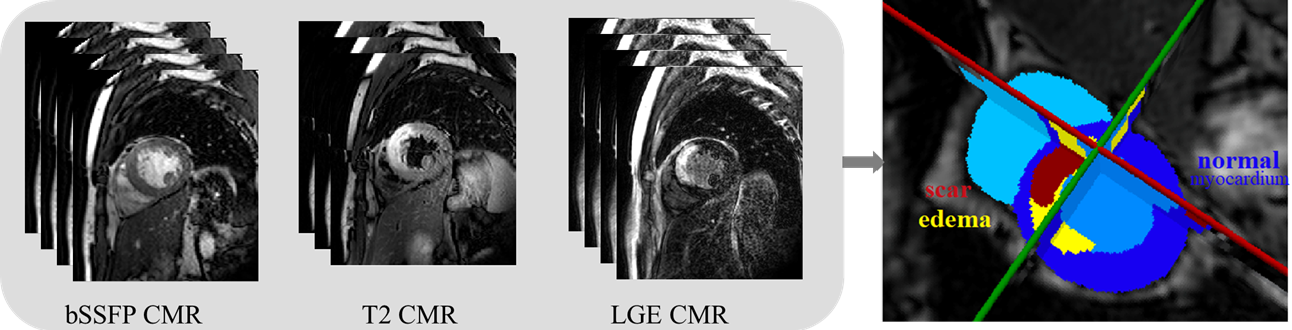


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import cv2
import os
import random
import tensorflow
from tensorflow import keras
from skimage.transform import resize
import tensorflow.keras.backend as K
from tensorflow.keras.models import *
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
import imageio
import imgaug as ia
import imgaug.augmenters as iaa
from imgaug.augmentables.segmaps import SegmentationMapsOnImage
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
import imgaug as ia
import nibabel as nib
from nilearn import plotting
# Seeding 
seed = 2019
random.seed = seed
np.random.seed = seed
from RUNet import RUNet
from metrics import multi_class_dice, multiclass_dice_loss, dice_background, dice_LVbloodpool, dice_RVbloodpool,dice_LVmyo, dice_LVmyoedema, dice_LVmyoscars

C:\Users\Elif\anaconda\lib\site-packages\nilearn\datasets\__init__.py:86: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [2]:
#Getting all images from folders
def get_all_images(folder, ext):

    all_files = []
    for file in os.listdir(folder):     
        _,  file_ext = os.path.splitext(file)       
        if ext in file_ext:
            full_file_path = os.path.join(folder, file)
            all_files.append(full_file_path)
    return all_files

filepath1 = "train25_myops_gd"
files = get_all_images(filepath1, 'gz')
filepath2= "train25"
files_img = get_all_images(filepath2, "gz")
filepath3= "test20"
files_test = get_all_images(filepath3, "gz")
files.sort()
files_img.sort()
files_test.sort()

## Data Preprocessing

In [3]:
#Ground Truth Masks for LV, RV and myocardium
image_width = 400
image_height = 400
t=0
for i in range(len(files)):
    c=nib.load(files[i]).shape[2]
    t=t+c   

Y_train = np.zeros((t, image_width, image_height))    
k=0
for i in range(len(files)):
    c=nib.load(files[i]).shape[2]
    for j in range(c):
        mask=nib.load(files[i])
        mask=mask.get_fdata()
        mask=mask[:,:,j]
        mask=cv2.resize(mask,(image_width, image_height),interpolation=cv2.INTER_NEAREST)
        Y_train[k]=mask
        k=k+1
y_train_v1=Y_train
Y_train[Y_train==500]=1      #to use to_categorical function  
Y_train[Y_train==600]=2       
Y_train[Y_train==200]=3         
Y_train[Y_train==1220]=4        
Y_train[Y_train==2221]=5     
Y_train=Y_train[:,72:328,72:328] #cropping to 256x256

In [4]:
#X_test

image_width = 400
image_height = 400
t=0
for i in range(len(files_test)):
    c=nib.load(files_test[i]).shape[2]
    t=t+c 
t=int(t/3)   
X_test = np.zeros((t, image_height, image_width,3)) 
C0=[x for x in files_test if 'C0' in x]
DE=[x for x in files_test if 'DE' in x]
T2=[x for x in files_test if 'T2' in x]
X_C0 = np.zeros((t, image_height, image_width))
X_DE = np.zeros((t, image_height, image_width))
X_T2 = np.zeros((t, image_height, image_width))

k=0
for i in range(len(C0)):
    c=nib.load(C0[i]).shape[2]
    for j in range(c):
        img=nib.load(C0[i])
        img=img.get_fdata()
        img=img[:,:,j]
        img=resize(img,(image_height, image_width))
        X_C0[k,:,:]=img 
        k=k+1
l=0        
for i in range(len(DE)):
    c=nib.load(DE[i]).shape[2]
    for j in range(c):
        img=nib.load(DE[i])
        img=img.get_fdata()
        img=img[:,:,j]
        img=resize(img,(image_height, image_width))        
        X_DE[l,:,:]=img 
        l=l+1  
m=0        
for i in range(len(T2)):
    c=nib.load(T2[i]).shape[2]
    for j in range(c):
        img=nib.load(T2[i])
        img=img.get_fdata()
        img=img[:,:,j]
        img=resize(img,(image_height, image_width))
        
        X_T2[m,:,:]=img 
        m=m+1 
        
X_test[:,:,:,0]=X_C0
X_test[:,:,:,1]=X_DE
X_test[:,:,:,2]=X_T2

X_test_256=X_test[:,72:328,72:328,:] #cropping images with 256x256 using the center point

#Normalizing

X_test256=np.zeros((X_test_256.shape[0], X_test_256.shape[1], X_test_256.shape[2], X_test_256.shape[3])) 
for i in range(X_test_256.shape[0]):
    X_test256[i]=X_test_256[i,:,:,:]/np.max(X_test_256[i,:,:,:])

In [5]:
#X_train

image_width = 400
image_height = 400
img_channels = 1


t=0
for i in range(len(files)):
    c=nib.load(files[i]).shape[2]
    t=t+c 
  
X_train = np.zeros((t, image_height, image_width,3)) 


C0=[x for x in files_img if 'C0' in x]
DE=[x for x in files_img if 'DE' in x]
T2=[x for x in files_img if 'T2' in x]
X_C0 = np.zeros((t, image_height, image_width))
X_DE = np.zeros((t, image_height, image_width))
X_T2 = np.zeros((t, image_height, image_width))

k=0
for i in range(len(C0)):
    c=nib.load(C0[i]).shape[2]
    for j in range(c):
        img=nib.load(C0[i])
        img=img.get_fdata()
        img=img[:,:,j]
        img=resize(img,(image_height, image_width))
        X_C0[k,:,:]=img 
        k=k+1
l=0        
for i in range(len(DE)):
    c=nib.load(DE[i]).shape[2]
    for j in range(c):
        img=nib.load(DE[i])
        img=img.get_fdata()
        img=img[:,:,j]
        img=resize(img,(image_height, image_width))        
        X_DE[l,:,:]=img 
        l=l+1  
m=0        
for i in range(len(T2)):
    c=nib.load(T2[i]).shape[2]
    for j in range(c):
        img=nib.load(T2[i])
        img=img.get_fdata()
        img=img[:,:,j]
        img=resize(img,(image_height, image_width))
        
        X_T2[m,:,:]=img 
        m=m+1 
        
X_train[:,:,:,0]=X_C0
X_train[:,:,:,1]=X_DE
X_train[:,:,:,2]=X_T2

X_train2=X_train[:,72:328,72:328,:]

#Normalizing
x_train_n=np.zeros((X_train2.shape[0], X_train2.shape[1], X_train2.shape[2], X_train2.shape[3])) 
for i in range(X_train2.shape[0]):
    x_train_n[i]=X_train2[i,:,:,:]/np.max(X_train2[i,:,:,:])
    
#CMR images with 3 channels
x_train=x_train_n

#Converting Y_train to binary class matrix
y_train=to_categorical(Y_train)

Text(0.5, 0, 'T2')

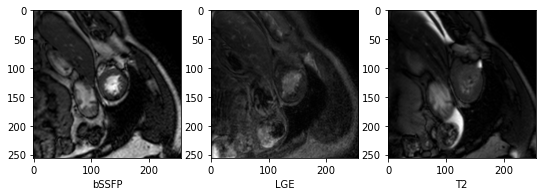

In [6]:
#An example of multi-sequence CMR image from training dataset.
plt.figure(figsize = (9,9))
plt.subplot(1,3,1)
plt.imshow(x_train[0,:,:,0], cmap='gray')
plt.xlabel("bSSFP")
plt.subplot(1,3,2)
plt.imshow(x_train[0,:,:,1], cmap='gray')
plt.xlabel("LGE")
plt.subplot(1,3,3)
plt.imshow(x_train[0,:,:,2], cmap='gray')
plt.xlabel("T2")

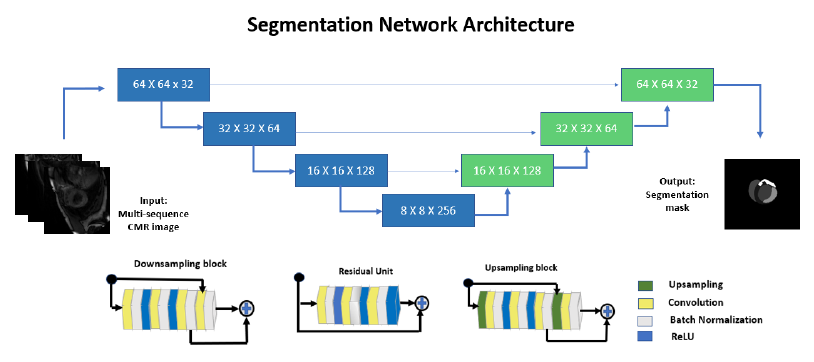

## Data Augmentation

In [7]:
# Define an example segmentation map

image = np.stack((x_train[0,:,:,0]*255,)*3, axis=-1)
image = image.astype(np.uint8)
segmap = SegmentationMapsOnImage(y_train[0,:,:,:], shape=image.shape)
#droupout
ia.seed(1)
# Define our augmentation pipeline.
seq = iaa.Sequential([
    iaa.Dropout([0.01, 0.05]),       # drop 1% or 5% of all pixels
    #iaa.Sharpen((0.0, 0.3)),        # sharpen the image
    iaa.Affine(rotate=(-90, 90)),    # rotate by -90 to 90 degrees (affects segmaps)      
    #iaa.ContrastNormalization((0.75, 1.5)),     
    iaa.ElasticTransformation(alpha=25, sigma=7),  # apply water effect (affects segmaps)
    iaa.Fliplr(0.5),                # horizontally flip 50% of the images

], random_order=True)

# Augment images and segmaps.
images_aug = []
segmaps_aug = []
for _ in range(5):
    images_aug_i, segmaps_aug_i = seq(image=image, segmentation_maps=segmap)
    images_aug.append(images_aug_i)
    segmaps_aug.append(segmaps_aug_i)

cells = []
for image_aug, segmap_aug in zip(images_aug, segmaps_aug):
    cells.append(image)                                         # column 1
    cells.append(segmap.draw_on_image(image)[0])                # column 2
    cells.append(image_aug)                                     # column 3
    cells.append(segmap_aug.draw_on_image(image_aug)[0])        # column 4
    cells.append(segmap_aug.draw(size=image_aug.shape[:2])[0])  # column 5

# Convert cells to a grid image and save.
grid_image = ia.draw_grid(cells, cols=5)
imageio.imwrite("example_segmaps.jpg", grid_image) #save an example augmented image & mask

C:\Users\Elif\anaconda\lib\site-packages\imgaug\imgaug.py:106: DeprecationWarning: Got a float array as the segmentation map in SegmentationMapsOnImage. That is deprecated. Please provide instead a (H,W,[C]) array of dtype bool_, int or uint, where C denotes the segmentation map index.
  warn(msg, category=DeprecationWarning, stacklevel=stacklevel)


#### Visualizing an augmented image and its ground truth mask 

First column is for original MR image, second column is for original image with ground truth mask, third column is for augmented image, fourth column is for augmented ground truth mask on augmented image and last column is for augmented ground truth
mask on its own in.
![example_segmaps](https://user-images.githubusercontent.com/44237325/125140783-f4a8c580-e11b-11eb-9e78-a264023ecec2.jpg)



In [8]:
seq = iaa.Sequential([                      
    iaa.Dropout([0.01, 0.05]),      # drop 5% or 20% of all pixels
    #iaa.Sharpen((0.0, 0.3)),       # sharpen the image
    iaa.Affine(rotate=(-90, 90)),  # rotate by -45 to 45 degrees (affects segmaps)      
    #iaa.ContrastNormalization((0.75, 1.5)),     
    iaa.ElasticTransformation(alpha=25, sigma=7),  # apply water effect (affects segmaps)
    iaa.Fliplr(0.5), # horizontally flip 50% of the images
], random_order=True)

seq_det = seq.to_deterministic()
seq2_det = seq.to_deterministic()
seq3_det = seq.to_deterministic()
seq4_det = seq.to_deterministic()
seq5_det = seq.to_deterministic()
seq6_det = seq.to_deterministic()
seq7_det = seq.to_deterministic()
seq8_det = seq.to_deterministic()
seq9_det = seq.to_deterministic()

# Train augmentation
def do_augmentation(seq_det, X_train, y_train):    
    X_train_aug = [(x[:,:,:] * 255.0).astype(np.uint8) for x in X_train]  
    X_train_aug = seq_det.augment_images(X_train_aug)
    X_train_aug = [(x[:,:,:].astype(np.float64)) / 255.0 for x in X_train_aug]
    y_train_aug = [(x[:,:,:] * 255.0).astype(np.uint8) for x in y_train]   
    y_train_aug = seq_det.augment_images(y_train_aug)   
    y_train_aug = [np.where(x[:,:,:] > 0, 255, 0) for x in y_train_aug]  
    y_train_aug = [(x[:,:,:].astype(np.float64)) / 255.0 for x in y_train_aug]
    X_train_aug=np.array(X_train_aug)
    y_train_aug=np.array(y_train_aug)
    return X_train_aug, y_train_aug

In [9]:
# to allocate an array with shape and data type
physical_devices = tensorflow.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
   tensorflow.config.experimental.set_memory_growth(physical_devices[0], True)

In [10]:
#Increasing the dataset ten times
X_train_aug=do_augmentation(seq_det, x_train, y_train)[0]
y_train_aug=do_augmentation(seq_det, x_train, y_train)[1]
X_train_aug2=do_augmentation(seq2_det,x_train, y_train)[0]
y_train_aug2=do_augmentation(seq2_det, x_train, y_train)[1]
X_train_aug3=do_augmentation(seq3_det, x_train, y_train)[0]
y_train_aug3=do_augmentation(seq3_det, x_train, y_train)[1]
X_train_aug4=do_augmentation(seq4_det, x_train, y_train)[0]
y_train_aug4=do_augmentation(seq4_det, x_train, y_train)[1]
X_train_aug5=do_augmentation(seq5_det, x_train, y_train)[0]
y_train_aug5=do_augmentation(seq5_det, x_train, y_train)[1]
X_train_aug6=do_augmentation(seq6_det, x_train, y_train)[0]
y_train_aug6=do_augmentation(seq6_det, x_train, y_train)[1]
X_train_aug7=do_augmentation(seq7_det, x_train, y_train)[0]
y_train_aug7=do_augmentation(seq7_det, x_train, y_train)[1]
X_train_aug8=do_augmentation(seq8_det, x_train, y_train)[0]
y_train_aug8=do_augmentation(seq8_det, x_train, y_train)[1]
X_train_aug9=do_augmentation(seq9_det, x_train, y_train)[0]
y_train_aug9=do_augmentation(seq9_det, x_train, y_train)[1]

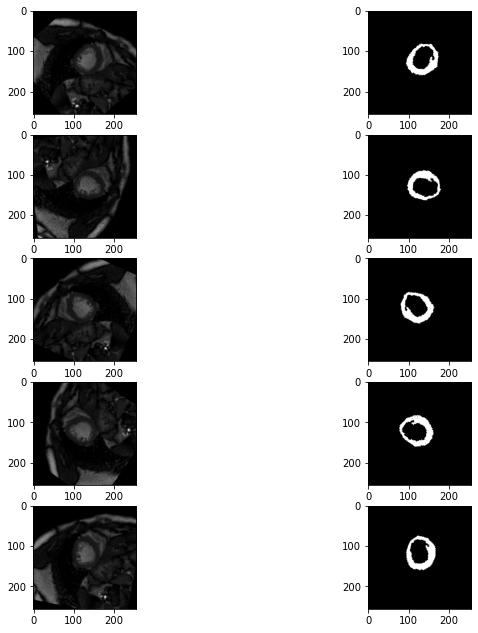

In [11]:
# Plotting an image and its mask of myocardium for each augmentation set
idx = random.randint(0, len(x_train))
plt.figure(figsize = (11,11))
plt.subplot(5,2,1)
plt.imshow(X_train_aug[idx,:,:,0], cmap='gray')
plt.subplot(5,2,2)
plt.imshow(y_train_aug[idx,:,:,3], cmap='gray')
plt.subplot(5,2,3)
plt.imshow(X_train_aug2[idx,:,:,0], cmap='gray')
plt.subplot(5,2,4)
plt.imshow(y_train_aug2[idx,:,:,3], cmap='gray')
plt.subplot(5,2,5)
plt.imshow(X_train_aug3[idx,:,:,0], cmap='gray')
plt.subplot(5,2,6)
plt.imshow(y_train_aug3[idx,:,:,3], cmap='gray')
plt.subplot(5,2,7)
plt.imshow(X_train_aug4[idx,:,:,0], cmap='gray')
plt.subplot(5,2,8)
plt.imshow(y_train_aug4[idx,:,:,3], cmap='gray')
plt.subplot(5,2,9)
plt.imshow(X_train_aug5[idx,:,:,0], cmap='gray')
plt.subplot(5,2,10)
plt.imshow(y_train_aug5[idx,:,:,3], cmap='gray')

In [12]:
#Combining the augmented sets
xt1_aug=np.concatenate((x_train, X_train_aug, X_train_aug2,X_train_aug3,X_train_aug4,X_train_aug5,X_train_aug6,X_train_aug7,X_train_aug8,X_train_aug9),axis=0)
yt1_aug=np.concatenate((y_train, y_train_aug, y_train_aug2,y_train_aug3,y_train_aug4,y_train_aug5,y_train_aug6,y_train_aug7,y_train_aug8,y_train_aug9), axis=0)

In [13]:
earlystopper = EarlyStopping(patience=10, verbose=1)
#checkpointer = ModelCheckpoint(filepath = 'model_unet_4ch.hdf5', verbose=1,save_best_only=True, save_weights_only = True)
model_save = ModelCheckpoint('best_all_runet.hdf5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.5,
                              patience=10, min_lr=0.00001, verbose=1,  cooldown=1)

In [14]:
model_aug = RUNet(i=16, axis=3, classes=6)

In [15]:
#model_aug.summary()

In [16]:
history_aug=model_aug.fit(xt1_aug, yt1_aug, batch_size=8, epochs=750, verbose=1, callbacks=[reduce_lr])

Epoch 1/750
128/128 [==============================] - 8s 66ms/step - loss: 0.5413 - dice_background: 0.8754 - dice_LVbloodpool: 0.6139 - dice_RVbloodpool: 0.4829 - dice_LVmyo: 0.3768 - dice_LVmyoedema: 0.1964 - dice_LVmyoscars: 0.2107 - multi_class_dice: 0.4593
Epoch 2/750
128/128 [==============================] - 8s 61ms/step - loss: 0.3326 - dice_background: 0.8926 - dice_LVbloodpool: 0.8574 - dice_RVbloodpool: 0.7920 - dice_LVmyo: 0.6713 - dice_LVmyoedema: 0.3416 - dice_LVmyoscars: 0.4483 - multi_class_dice: 0.6672
Epoch 3/750
128/128 [==============================] - 8s 61ms/step - loss: 0.2850 - dice_background: 0.9231 - dice_LVbloodpool: 0.8835 - dice_RVbloodpool: 0.8420 - dice_LVmyo: 0.7324 - dice_LVmyoedema: 0.3685 - dice_LVmyoscars: 0.5414 - multi_class_dice: 0.7152: 3s - loss: 0.2884 - dice_background: 0.9206 - dice_LVbloodpool: 0.8820 - dice_RVbloodpool: 0.8360 - dice_LVmyo: 0.7298 - dice_LVmyoedema: 0
Epoch 4/750
128/128 [==============================] - 8s 61ms/step - 

128/128 [==============================] - 8s 62ms/step - loss: 0.0916 - dice_background: 0.9340 - dice_LVbloodpool: 0.9533 - dice_RVbloodpool: 0.9485 - dice_LVmyo: 0.8940 - dice_LVmyoedema: 0.8393 - dice_LVmyoscars: 0.8807 - multi_class_dice: 0.9083
Epoch 58/750
128/128 [==============================] - 8s 62ms/step - loss: 0.0942 - dice_background: 0.9340 - dice_LVbloodpool: 0.9522 - dice_RVbloodpool: 0.9477 - dice_LVmyo: 0.8915 - dice_LVmyoedema: 0.8308 - dice_LVmyoscars: 0.8787 - multi_class_dice: 0.9058
Epoch 59/750
128/128 [==============================] - 8s 62ms/step - loss: 0.0967 - dice_background: 0.9340 - dice_LVbloodpool: 0.9512 - dice_RVbloodpool: 0.9460 - dice_LVmyo: 0.8876 - dice_LVmyoedema: 0.8267 - dice_LVmyoscars: 0.8741 - multi_class_dice: 0.9033
Epoch 60/750
128/128 [==============================] - 8s 62ms/step - loss: 0.0948 - dice_background: 0.9339 - dice_LVbloodpool: 0.9515 - dice_RVbloodpool: 0.9473 - dice_LVmyo: 0.8900 - dice_LVmyoedema: 0.8336 - dice_LVm

128/128 [==============================] - 8s 62ms/step - loss: 0.0713 - dice_background: 0.9347 - dice_LVbloodpool: 0.9622 - dice_RVbloodpool: 0.9623 - dice_LVmyo: 0.9167 - dice_LVmyoedema: 0.8804 - dice_LVmyoscars: 0.9158 - multi_class_dice: 0.9287
Epoch 119/750
128/128 [==============================] - 8s 62ms/step - loss: 0.0707 - dice_background: 0.9347 - dice_LVbloodpool: 0.9625 - dice_RVbloodpool: 0.9632 - dice_LVmyo: 0.9167 - dice_LVmyoedema: 0.8804 - dice_LVmyoscars: 0.9180 - multi_class_dice: 0.9293
Epoch 120/750
128/128 [==============================] - 8s 62ms/step - loss: 0.0713 - dice_background: 0.9346 - dice_LVbloodpool: 0.9620 - dice_RVbloodpool: 0.9622 - dice_LVmyo: 0.9161 - dice_LVmyoedema: 0.8808 - dice_LVmyoscars: 0.9162 - multi_class_dice: 0.9286
Epoch 121/750
128/128 [==============================] - 8s 62ms/step - loss: 0.0701 - dice_background: 0.9346 - dice_LVbloodpool: 0.9626 - dice_RVbloodpool: 0.9637 - dice_LVmyo: 0.9175 - dice_LVmyoedema: 0.8819 - dice_

128/128 [==============================] - 8s 62ms/step - loss: 0.0629 - dice_background: 0.9349 - dice_LVbloodpool: 0.9672 - dice_RVbloodpool: 0.9676 - dice_LVmyo: 0.9277 - dice_LVmyoedema: 0.8973 - dice_LVmyoscars: 0.9281 - multi_class_dice: 0.9371
Epoch 179/750
128/128 [==============================] - 8s 62ms/step - loss: 0.0628 - dice_background: 0.9348 - dice_LVbloodpool: 0.9669 - dice_RVbloodpool: 0.9674 - dice_LVmyo: 0.9280 - dice_LVmyoedema: 0.8965 - dice_LVmyoscars: 0.9296 - multi_class_dice: 0.9372
Epoch 180/750
128/128 [==============================] - 8s 62ms/step - loss: 0.0627 - dice_background: 0.9348 - dice_LVbloodpool: 0.9674 - dice_RVbloodpool: 0.9670 - dice_LVmyo: 0.9280 - dice_LVmyoedema: 0.8968 - dice_LVmyoscars: 0.9294 - multi_class_dice: 0.9372
Epoch 181/750
128/128 [==============================] - 8s 62ms/step - loss: 0.0626 - dice_background: 0.9349 - dice_LVbloodpool: 0.9675 - dice_RVbloodpool: 0.9680 - dice_LVmyo: 0.9278 - dice_LVmyoedema: 0.8966 - dice_

128/128 [==============================] - 8s 62ms/step - loss: 0.0493 - dice_background: 0.9886 - dice_LVbloodpool: 0.9698 - dice_RVbloodpool: 0.9702 - dice_LVmyo: 0.9338 - dice_LVmyoedema: 0.9063 - dice_LVmyoscars: 0.9352 - multi_class_dice: 0.9506
Epoch 239/750
128/128 [==============================] - 8s 62ms/step - loss: 0.0488 - dice_background: 0.9888 - dice_LVbloodpool: 0.9701 - dice_RVbloodpool: 0.9706 - dice_LVmyo: 0.9344 - dice_LVmyoedema: 0.9069 - dice_LVmyoscars: 0.9355 - multi_class_dice: 0.9511
Epoch 240/750
128/128 [==============================] - ETA: 0s - loss: 0.0492 - dice_background: 0.9887 - dice_LVbloodpool: 0.9700 - dice_RVbloodpool: 0.9697 - dice_LVmyo: 0.9338 - dice_LVmyoedema: 0.9064 - dice_LVmyoscars: 0.9361 - multi_class_dice: 0.950 - 8s 62ms/step - loss: 0.0492 - dice_background: 0.9887 - dice_LVbloodpool: 0.9700 - dice_RVbloodpool: 0.9697 - dice_LVmyo: 0.9338 - dice_LVmyoedema: 0.9064 - dice_LVmyoscars: 0.9361 - multi_class_dice: 0.9508
Epoch 241/750
1

128/128 [==============================] - 8s 62ms/step - loss: 0.0411 - dice_background: 0.9919 - dice_LVbloodpool: 0.9736 - dice_RVbloodpool: 0.9750 - dice_LVmyo: 0.9428 - dice_LVmyoedema: 0.9228 - dice_LVmyoscars: 0.9476 - multi_class_dice: 0.9589
Epoch 297/750
128/128 [==============================] - 8s 62ms/step - loss: 0.0411 - dice_background: 0.9920 - dice_LVbloodpool: 0.9737 - dice_RVbloodpool: 0.9747 - dice_LVmyo: 0.9426 - dice_LVmyoedema: 0.9232 - dice_LVmyoscars: 0.9474 - multi_class_dice: 0.9589
Epoch 298/750
128/128 [==============================] - 8s 62ms/step - loss: 0.0409 - dice_background: 0.9921 - dice_LVbloodpool: 0.9737 - dice_RVbloodpool: 0.9748 - dice_LVmyo: 0.9432 - dice_LVmyoedema: 0.9226 - dice_LVmyoscars: 0.9481 - multi_class_dice: 0.9591
Epoch 299/750
128/128 [==============================] - 8s 62ms/step - loss: 0.0407 - dice_background: 0.9921 - dice_LVbloodpool: 0.9739 - dice_RVbloodpool: 0.9749 - dice_LVmyo: 0.9430 - dice_LVmyoedema: 0.9238 - dice_

128/128 [==============================] - 8s 62ms/step - loss: 0.0367 - dice_background: 0.9928 - dice_LVbloodpool: 0.9754 - dice_RVbloodpool: 0.9771 - dice_LVmyo: 0.9478 - dice_LVmyoedema: 0.9326 - dice_LVmyoscars: 0.9538 - multi_class_dice: 0.9632
Epoch 356/750
128/128 [==============================] - 8s 62ms/step - loss: 0.0365 - dice_background: 0.9929 - dice_LVbloodpool: 0.9757 - dice_RVbloodpool: 0.9772 - dice_LVmyo: 0.9479 - dice_LVmyoedema: 0.9332 - dice_LVmyoscars: 0.9543 - multi_class_dice: 0.9635
Epoch 357/750
128/128 [==============================] - 8s 62ms/step - loss: 0.0366 - dice_background: 0.9928 - dice_LVbloodpool: 0.9758 - dice_RVbloodpool: 0.9771 - dice_LVmyo: 0.9479 - dice_LVmyoedema: 0.9323 - dice_LVmyoscars: 0.9542 - multi_class_dice: 0.9634
Epoch 358/750
128/128 [==============================] - 8s 62ms/step - loss: 0.0365 - dice_background: 0.9929 - dice_LVbloodpool: 0.9757 - dice_RVbloodpool: 0.9773 - dice_LVmyo: 0.9481 - dice_LVmyoedema: 0.9330 - dice_

128/128 [==============================] - 8s 62ms/step - loss: 0.0339 - dice_background: 0.9932 - dice_LVbloodpool: 0.9770 - dice_RVbloodpool: 0.9787 - dice_LVmyo: 0.9506 - dice_LVmyoedema: 0.9386 - dice_LVmyoscars: 0.9582 - multi_class_dice: 0.9661
Epoch 412/750
128/128 [==============================] - 8s 62ms/step - loss: 0.0342 - dice_background: 0.9932 - dice_LVbloodpool: 0.9767 - dice_RVbloodpool: 0.9785 - dice_LVmyo: 0.9506 - dice_LVmyoedema: 0.9389 - dice_LVmyoscars: 0.9572 - multi_class_dice: 0.9659: 0s - loss: 0.0341 - dice_background: 0.9933 - dice_LVbloodpool: 0.9766 - dice_RVbloodpool: 0.9787 - dice_LVmyo: 0.9505 - dice_LVmyoedema: 0.9392 - dice_LVmyoscars: 0.9570 - multi_cla
Epoch 413/750
128/128 [==============================] - 8s 62ms/step - loss: 0.0339 - dice_background: 0.9932 - dice_LVbloodpool: 0.9768 - dice_RVbloodpool: 0.9786 - dice_LVmyo: 0.9508 - dice_LVmyoedema: 0.9392 - dice_LVmyoscars: 0.9578 - multi_class_dice: 0.9661
Epoch 414/750
128/128 [============

128/128 [==============================] - 8s 62ms/step - loss: 0.0335 - dice_background: 0.9933 - dice_LVbloodpool: 0.9771 - dice_RVbloodpool: 0.9787 - dice_LVmyo: 0.9514 - dice_LVmyoedema: 0.9403 - dice_LVmyoscars: 0.9581 - multi_class_dice: 0.9665
Epoch 468/750
128/128 [==============================] - 8s 62ms/step - loss: 0.0335 - dice_background: 0.9933 - dice_LVbloodpool: 0.9771 - dice_RVbloodpool: 0.9787 - dice_LVmyo: 0.9512 - dice_LVmyoedema: 0.9400 - dice_LVmyoscars: 0.9589 - multi_class_dice: 0.9665: 5s - loss: 0.0373 - dice_background: 0.9931 - dice_LVbloodpool: 0.9746 -
Epoch 469/750
128/128 [==============================] - 8s 62ms/step - loss: 0.0335 - dice_background: 0.9933 - dice_LVbloodpool: 0.9771 - dice_RVbloodpool: 0.9787 - dice_LVmyo: 0.9511 - dice_LVmyoedema: 0.9403 - dice_LVmyoscars: 0.9588 - multi_class_dice: 0.9665
Epoch 470/750
128/128 [==============================] - 8s 62ms/step - loss: 0.0335 - dice_background: 0.9932 - dice_LVbloodpool: 0.9770 - dice_

128/128 [==============================] - 8s 62ms/step - loss: 0.0332 - dice_background: 0.9933 - dice_LVbloodpool: 0.9772 - dice_RVbloodpool: 0.9789 - dice_LVmyo: 0.9516 - dice_LVmyoedema: 0.9407 - dice_LVmyoscars: 0.9590 - multi_class_dice: 0.9668
Epoch 528/750
128/128 [==============================] - 8s 63ms/step - loss: 0.0332 - dice_background: 0.9933 - dice_LVbloodpool: 0.9772 - dice_RVbloodpool: 0.9788 - dice_LVmyo: 0.9515 - dice_LVmyoedema: 0.9409 - dice_LVmyoscars: 0.9591 - multi_class_dice: 0.9668
Epoch 529/750
128/128 [==============================] - 8s 62ms/step - loss: 0.0335 - dice_background: 0.9931 - dice_LVbloodpool: 0.9771 - dice_RVbloodpool: 0.9787 - dice_LVmyo: 0.9512 - dice_LVmyoedema: 0.9402 - dice_LVmyoscars: 0.9585 - multi_class_dice: 0.9665
Epoch 530/750
128/128 [==============================] - 8s 62ms/step - loss: 0.0333 - dice_background: 0.9933 - dice_LVbloodpool: 0.9769 - dice_RVbloodpool: 0.9788 - dice_LVmyo: 0.9515 - dice_LVmyoedema: 0.9406 - dice_

128/128 [==============================] - 8s 62ms/step - loss: 0.0331 - dice_background: 0.9933 - dice_LVbloodpool: 0.9772 - dice_RVbloodpool: 0.9788 - dice_LVmyo: 0.9515 - dice_LVmyoedema: 0.9409 - dice_LVmyoscars: 0.9595 - multi_class_dice: 0.9669
Epoch 587/750
128/128 [==============================] - 8s 62ms/step - loss: 0.0334 - dice_background: 0.9933 - dice_LVbloodpool: 0.9771 - dice_RVbloodpool: 0.9789 - dice_LVmyo: 0.9513 - dice_LVmyoedema: 0.9408 - dice_LVmyoscars: 0.9581 - multi_class_dice: 0.9666
Epoch 588/750
128/128 [==============================] - 8s 62ms/step - loss: 0.0333 - dice_background: 0.9933 - dice_LVbloodpool: 0.9770 - dice_RVbloodpool: 0.9786 - dice_LVmyo: 0.9513 - dice_LVmyoedema: 0.9408 - dice_LVmyoscars: 0.9590 - multi_class_dice: 0.9667
Epoch 589/750
128/128 [==============================] - 8s 62ms/step - loss: 0.0332 - dice_background: 0.9933 - dice_LVbloodpool: 0.9771 - dice_RVbloodpool: 0.9788 - dice_LVmyo: 0.9516 - dice_LVmyoedema: 0.9408 - dice_

128/128 [==============================] - 8s 62ms/step - loss: 0.0331 - dice_background: 0.9933 - dice_LVbloodpool: 0.9771 - dice_RVbloodpool: 0.9789 - dice_LVmyo: 0.9516 - dice_LVmyoedema: 0.9409 - dice_LVmyoscars: 0.9595 - multi_class_dice: 0.9669
Epoch 646/750
128/128 [==============================] - 8s 62ms/step - loss: 0.0332 - dice_background: 0.9933 - dice_LVbloodpool: 0.9772 - dice_RVbloodpool: 0.9789 - dice_LVmyo: 0.9516 - dice_LVmyoedema: 0.9412 - dice_LVmyoscars: 0.9587 - multi_class_dice: 0.9668
Epoch 647/750
128/128 [==============================] - 8s 62ms/step - loss: 0.0331 - dice_background: 0.9933 - dice_LVbloodpool: 0.9772 - dice_RVbloodpool: 0.9790 - dice_LVmyo: 0.9517 - dice_LVmyoedema: 0.9404 - dice_LVmyoscars: 0.9595 - multi_class_dice: 0.9669
Epoch 648/750
128/128 [==============================] - 8s 62ms/step - loss: 0.0333 - dice_background: 0.9933 - dice_LVbloodpool: 0.9771 - dice_RVbloodpool: 0.9789 - dice_LVmyo: 0.9515 - dice_LVmyoedema: 0.9406 - dice_

128/128 [==============================] - 8s 62ms/step - loss: 0.0331 - dice_background: 0.9933 - dice_LVbloodpool: 0.9771 - dice_RVbloodpool: 0.9789 - dice_LVmyo: 0.9517 - dice_LVmyoedema: 0.9409 - dice_LVmyoscars: 0.9592 - multi_class_dice: 0.9668
Epoch 706/750
128/128 [==============================] - 8s 62ms/step - loss: 0.0332 - dice_background: 0.9933 - dice_LVbloodpool: 0.9772 - dice_RVbloodpool: 0.9790 - dice_LVmyo: 0.9515 - dice_LVmyoedema: 0.9410 - dice_LVmyoscars: 0.9590 - multi_class_dice: 0.9668
Epoch 707/750
128/128 [==============================] - 8s 62ms/step - loss: 0.0332 - dice_background: 0.9933 - dice_LVbloodpool: 0.9772 - dice_RVbloodpool: 0.9789 - dice_LVmyo: 0.9517 - dice_LVmyoedema: 0.9406 - dice_LVmyoscars: 0.9593 - multi_class_dice: 0.9668
Epoch 708/750
128/128 [==============================] - 8s 62ms/step - loss: 0.0330 - dice_background: 0.9933 - dice_LVbloodpool: 0.9773 - dice_RVbloodpool: 0.9789 - dice_LVmyo: 0.9517 - dice_LVmyoedema: 0.9416 - dice_

In [17]:
model_aug.save('RUNet.h5')

In [18]:
model_load_aug=load_model('RUNet.h5', compile=False)
model_load_aug.compile(optimizer = tensorflow.keras.optimizers.Adam(lr = 0.001), loss = multiclass_dice_loss, 
              metrics = [dice_background,dice_LVbloodpool,dice_RVbloodpool,dice_LVmyo, dice_LVmyoedema, dice_LVmyoscars, multi_class_dice])

In [19]:
results1=history_aug
keys=list(results1.history.keys())
for i in range(len(keys)):
  print("mean of %s : %0.3f (+/- %0.3f)" %  (keys[i],np.mean(results1.history[keys[i]]), np.std(results1.history[keys[i]]) * 2))
for i in range(len(keys)):
  print("highest of %s : %0.3f (+/- %0.3f)" %  (keys[i],np.max(results1.history[keys[i]]), np.std(results1.history[keys[i]]) * 2))
 

mean of loss : 0.052 (+/- 0.076)
mean of dice_background : 0.976 (+/- 0.053)
mean of dice_LVbloodpool : 0.970 (+/- 0.036)
mean of dice_RVbloodpool : 0.969 (+/- 0.050)
mean of dice_LVmyo : 0.934 (+/- 0.074)
mean of dice_LVmyoedema : 0.905 (+/- 0.153)
mean of dice_LVmyoscars : 0.933 (+/- 0.115)
mean of multi_class_dice : 0.948 (+/- 0.076)
mean of lr : 0.000 (+/- 0.001)
highest of loss : 0.541 (+/- 0.076)
highest of dice_background : 0.993 (+/- 0.053)
highest of dice_LVbloodpool : 0.977 (+/- 0.036)
highest of dice_RVbloodpool : 0.979 (+/- 0.050)
highest of dice_LVmyo : 0.952 (+/- 0.074)
highest of dice_LVmyoedema : 0.942 (+/- 0.153)
highest of dice_LVmyoscars : 0.960 (+/- 0.115)
highest of multi_class_dice : 0.967 (+/- 0.076)
highest of lr : 0.001 (+/- 0.001)


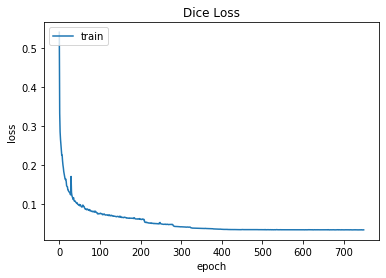

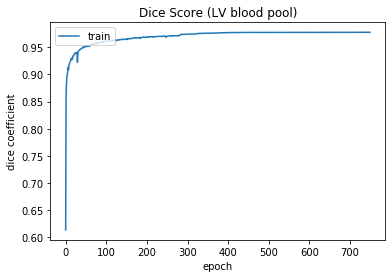

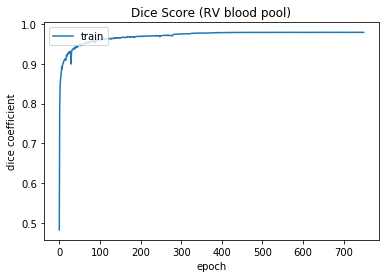

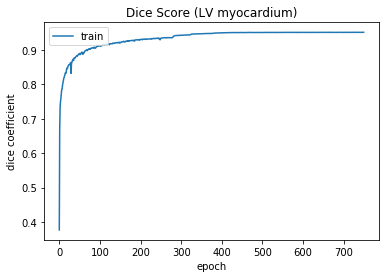

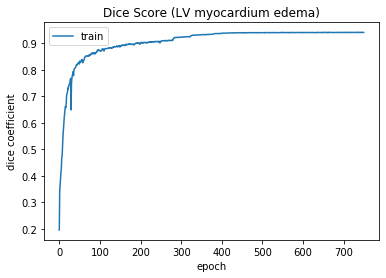

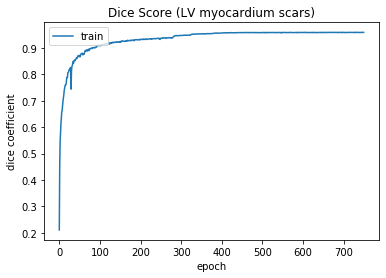

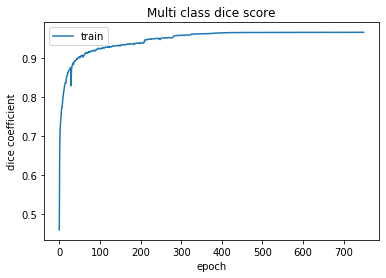

In [20]:
plt.plot(results1.history['loss'])
#plt.plot(results1.history['val_loss'])
plt.title('Dice Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

plt.plot(results1.history['dice_LVbloodpool'])
#plt.plot(results1.history['val_dice_LVbloodpool'])
plt.title('Dice Score (LV blood pool)')
plt.ylabel('dice coefficient')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()


plt.plot(results1.history['dice_RVbloodpool'])
#plt.plot(results1.history['val_dice_RVbloodpool'])
plt.title('Dice Score (RV blood pool)')
plt.ylabel('dice coefficient')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()


plt.plot(results1.history['dice_LVmyo'])
#plt.plot(results1.history['val_dice_LVmyo'])
plt.title('Dice Score (LV myocardium)')
plt.ylabel('dice coefficient')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()



plt.plot(results1.history['dice_LVmyoedema'])
#plt.plot(results1.history['val_dice_LVmyoedema'])
plt.title('Dice Score (LV myocardium edema)')
plt.ylabel('dice coefficient')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()



plt.plot(results1.history['dice_LVmyoscars'])
#plt.plot(results1.history['val_dice_LVmyoscars'])
plt.title('Dice Score (LV myocardium scars)')
plt.ylabel('dice coefficient')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()



plt.plot(results1.history['multi_class_dice'])
#plt.plot(results1.history['val_multi_class_dice'])
plt.title('Multi class dice score')
plt.ylabel('dice coefficient')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [21]:
preds_train_nt1 = model_load_aug.predict(x_train)
#preds_val_nt1 = model_aug.predict(xv1)
#preds_train_nt1 = model_load_aug.predict(xt1_aug)
#preds_val_nt1=model_load_aug.predict(xv1)

<Figure size 936x936 with 0 Axes>

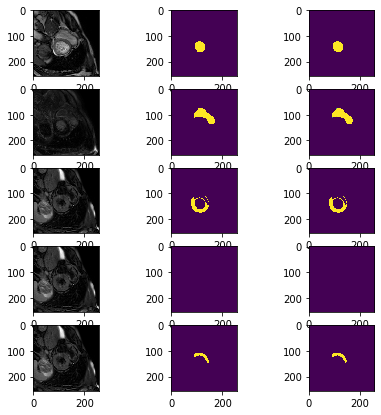

In [23]:
plt.figure(figsize = (13,13))
idx = random.randint(0, len(x_train))
plt.figure(figsize = (7,7))
plt.subplot(5,3,1)
plt.imshow(x_train[idx,:,:,0], cmap='gray')
plt.subplot(5,3,2)
plt.imshow(yt1_aug[idx,:,:,1])
plt.subplot(5,3,3)
plt.imshow(preds_train_nt1[idx,:,:,1])
plt.subplot(5,3,4)
plt.imshow(xt1_aug[idx,:,:,1], cmap='gray')
plt.subplot(5,3,5)
plt.imshow(yt1_aug[idx,:,:,2])
plt.subplot(5,3,6)
plt.imshow(preds_train_nt1[idx,:,:,2])
plt.subplot(5,3,7)
plt.imshow(xt1_aug[idx,:,:,2], cmap='gray')
plt.subplot(5,3,8)
plt.imshow(yt1_aug[idx,:,:,3])
plt.subplot(5,3,9)
plt.imshow(preds_train_nt1[idx,:,:,3])
plt.subplot(5,3,10)
plt.imshow(xt1_aug[idx,:,:,2], cmap='gray')
plt.subplot(5,3,11)
plt.imshow(yt1_aug[idx,:,:,4])
plt.subplot(5,3,12)
plt.imshow(preds_train_nt1[idx,:,:,4])
plt.subplot(5,3,13)
plt.imshow(xt1_aug[idx,:,:,2], cmap='gray')
plt.subplot(5,3,14)
plt.imshow(yt1_aug[idx,:,:,5])
plt.subplot(5,3,15)
plt.imshow(preds_train_nt1[idx,:,:,5])

In [24]:
#Predicting the masks on the test samples
preds_test=model_load_aug.predict(X_test256)
#preds_test=model.predict(X_test256)

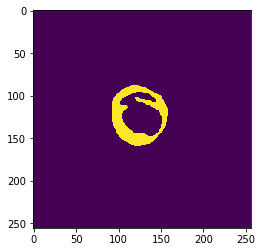

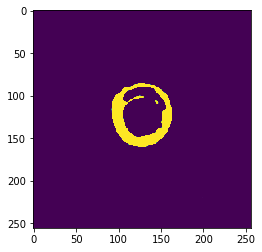

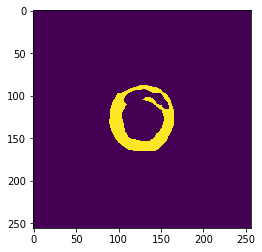

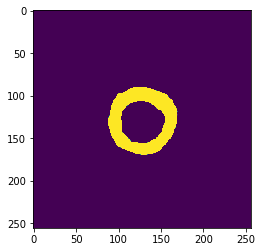

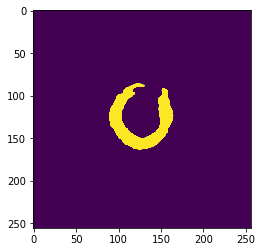

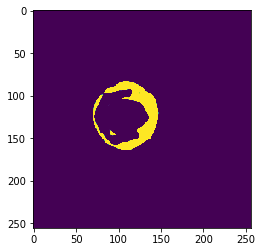

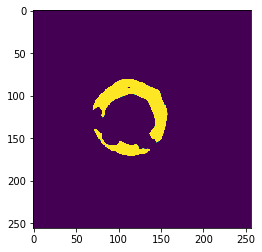

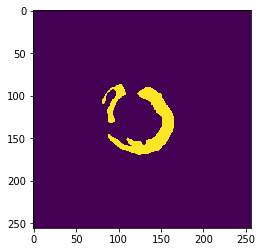

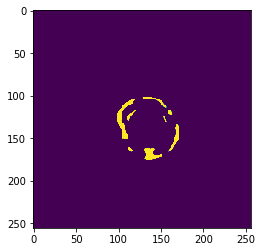

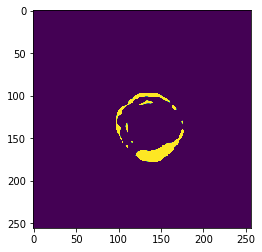

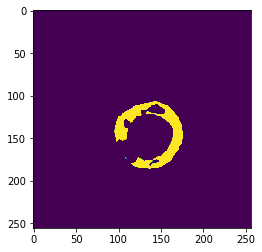

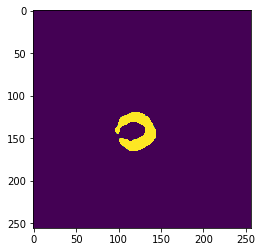

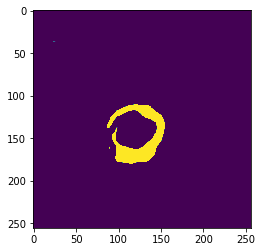

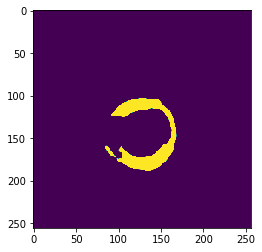

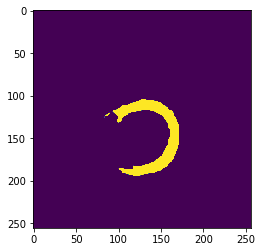

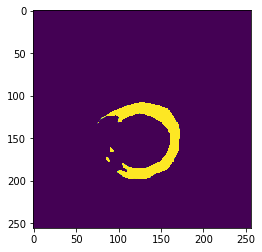

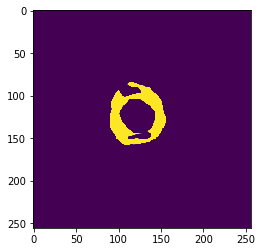

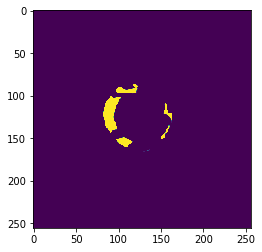

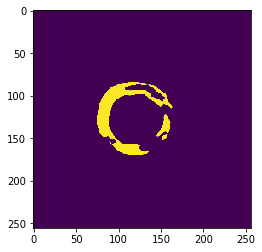

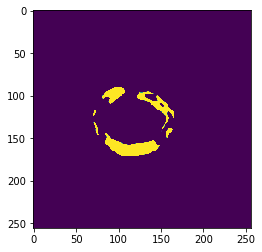

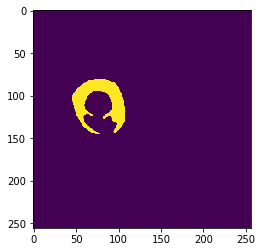

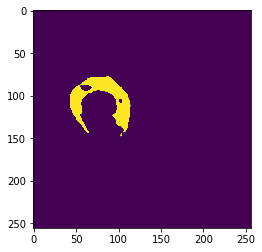

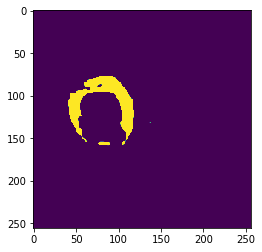

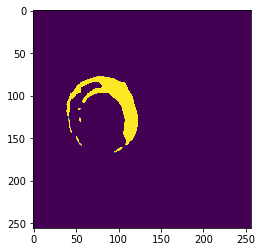

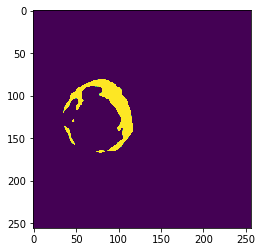

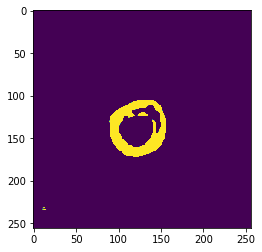

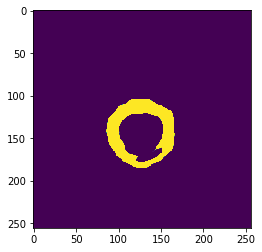

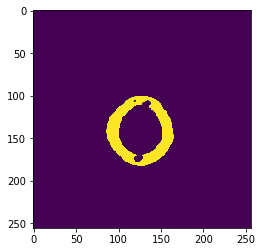

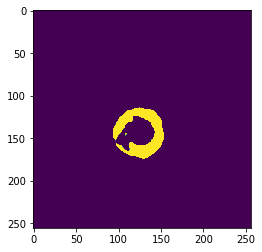

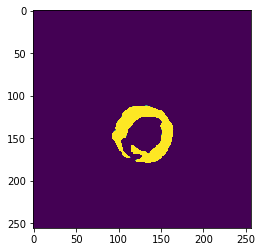

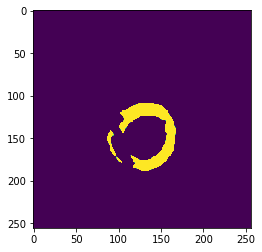

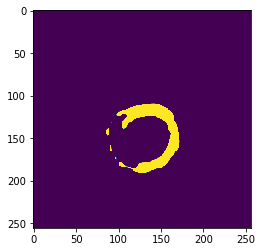

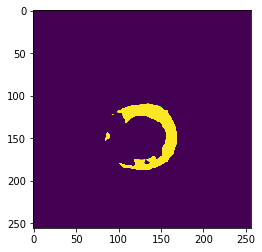

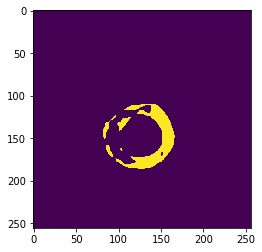

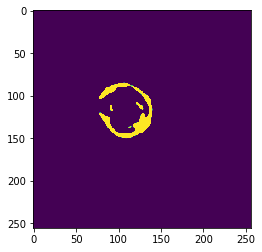

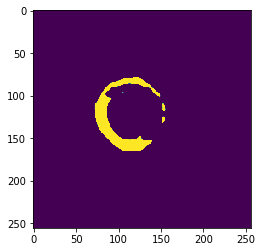

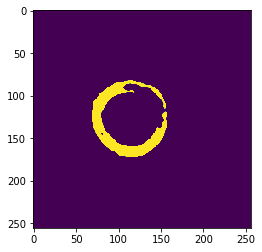

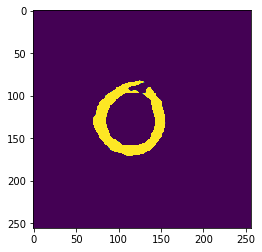

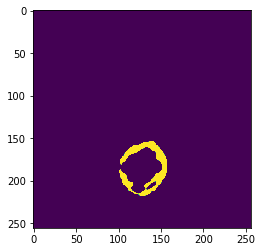

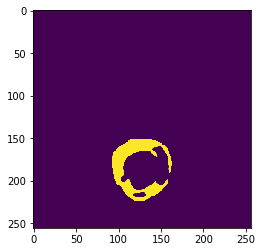

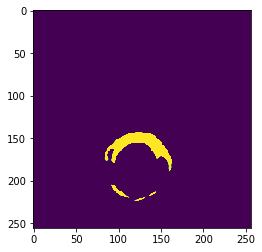

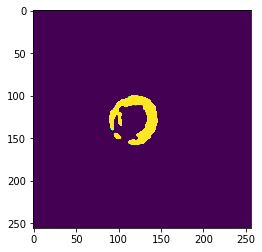

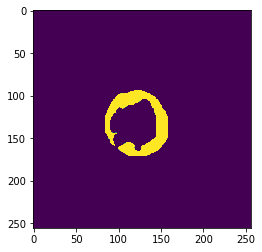

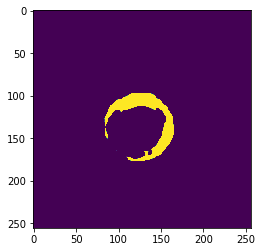

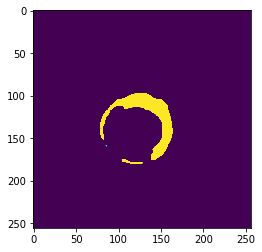

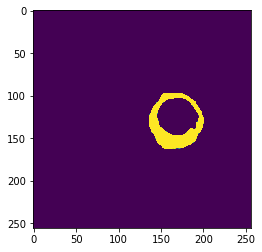

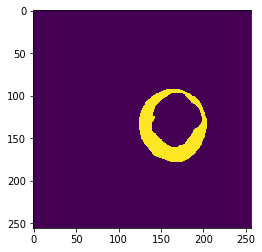

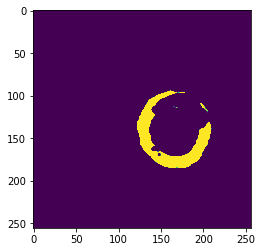

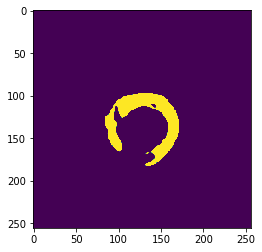

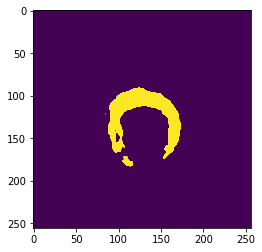

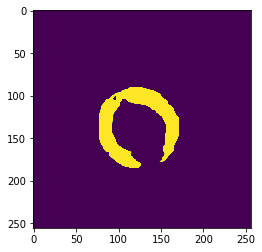

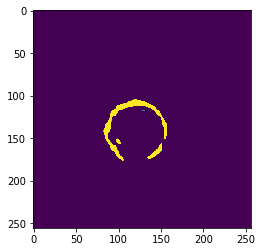

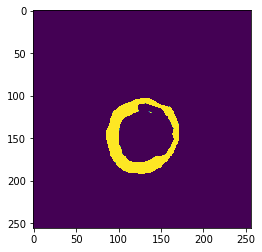

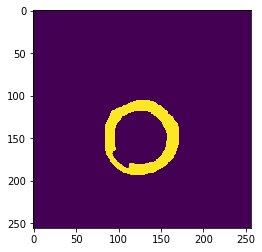

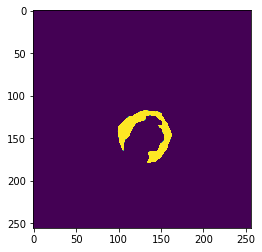

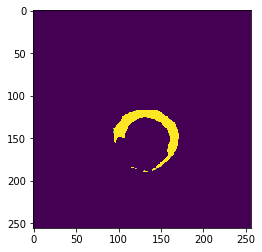

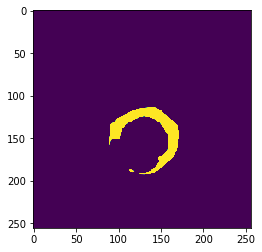

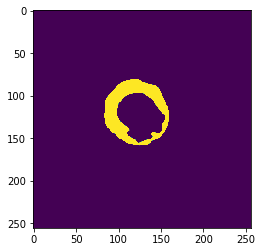

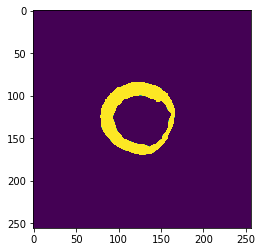

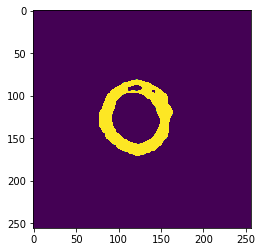

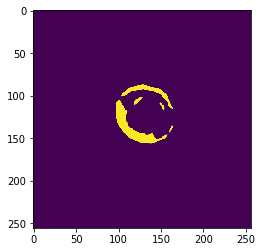

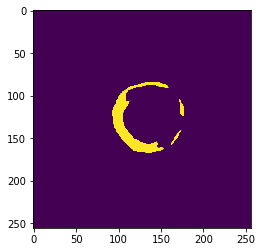

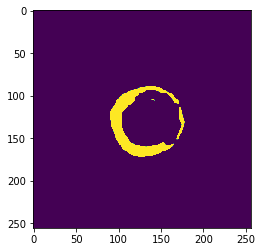

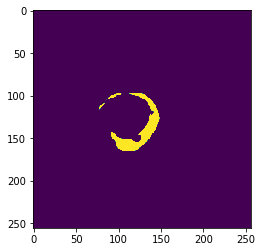

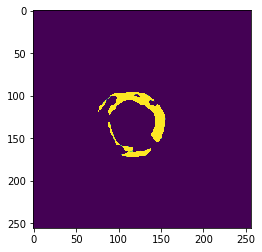

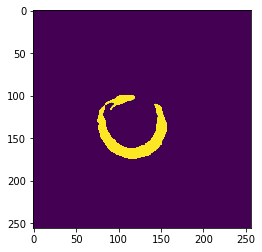

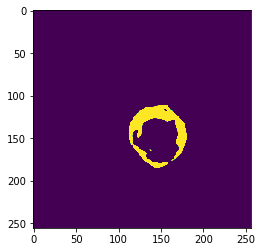

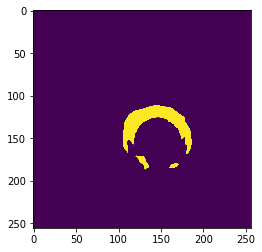

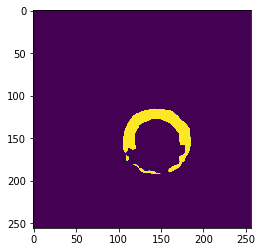

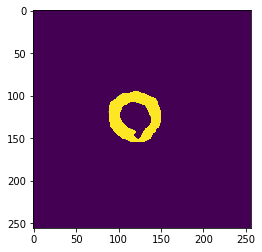

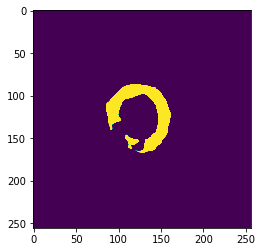

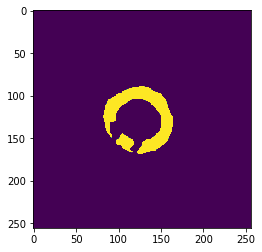

In [25]:
# Plots of predicted normal myocardium masks on the test set
for i in range(preds_test.shape[0]):
    plt.imshow(preds_test[i,:,:,3])
    plt.show()

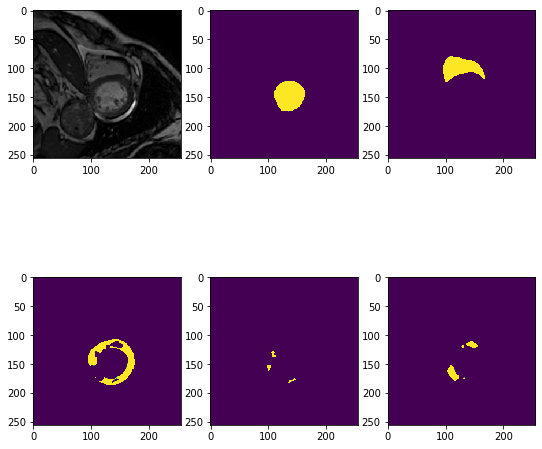

In [26]:
#Plot of predicted mask for all classes separately
plt.figure(figsize = (9,9))
idx = random.randint(0, 72)
plt.subplot(2,3,1)
plt.imshow(X_test_256[idx,:,:,0], cmap='gray' )
plt.subplot(2,3,2)
plt.imshow(preds_test[idx,:,:,1])
plt.subplot(2,3,3)
plt.imshow(preds_test[idx,:,:,2])
plt.subplot(2,3,4)
plt.imshow(preds_test[idx,:,:,3])
plt.subplot(2,3,5)
plt.imshow(preds_test[idx,:,:,4])
plt.subplot(2,3,6)
plt.imshow(preds_test[idx,:,:,5])

In [27]:
#Thresholding
image_width=X_test256.shape[1]
image_height=X_test256.shape[2]
preds = np.zeros((X_test256.shape[0], image_width, image_height)).astype('uint16')
preds[preds_test[:,:,:,0]>0.5]=0
preds[preds_test[:,:,:,1]>0.5]=500
preds[preds_test[:,:,:,2]>0.5]=600 
preds[preds_test[:,:,:,3]>0.5]=200
preds[preds_test[:,:,:,4]>0.5]=1220 
preds[preds_test[:,:,:,5]>0.5]=2221

1


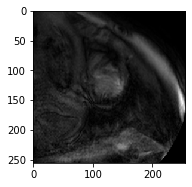

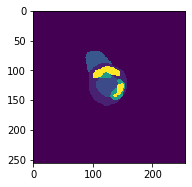

2


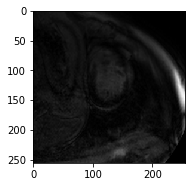

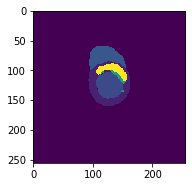

3


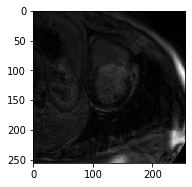

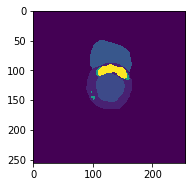

4


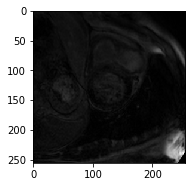

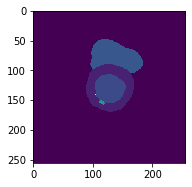

5


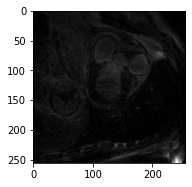

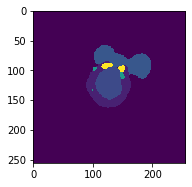

6


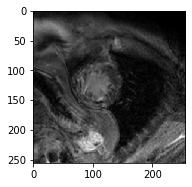

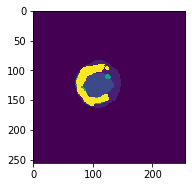

7


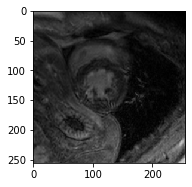

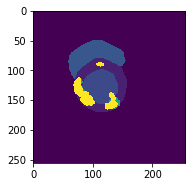

8


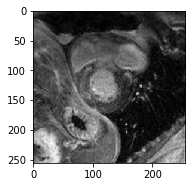

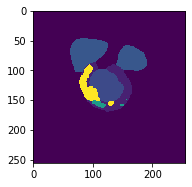

9


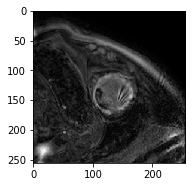

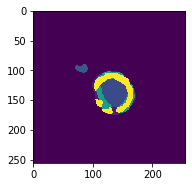

10


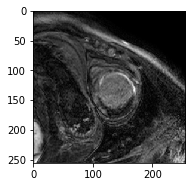

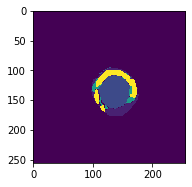

11


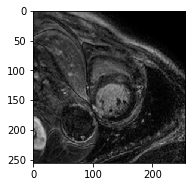

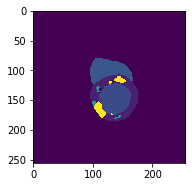

12


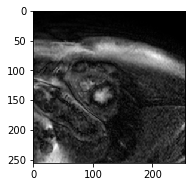

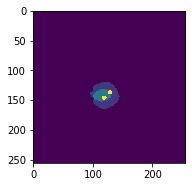

13


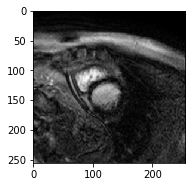

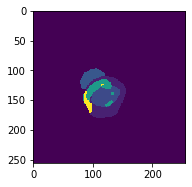

14


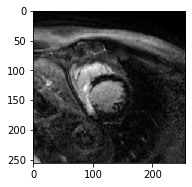

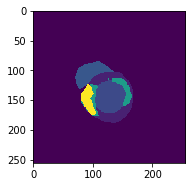

15


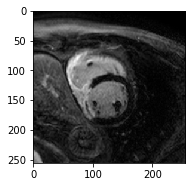

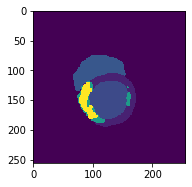

16


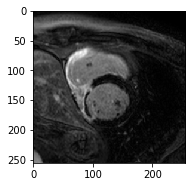

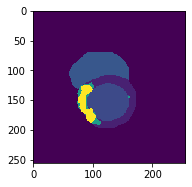

17


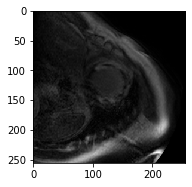

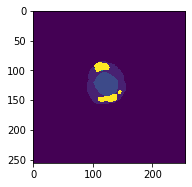

18


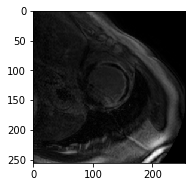

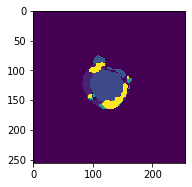

19


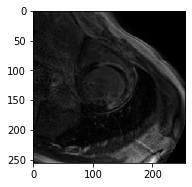

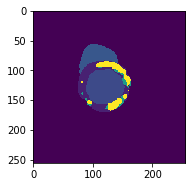

20


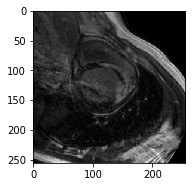

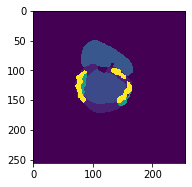

21


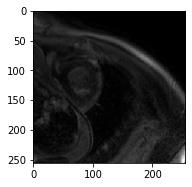

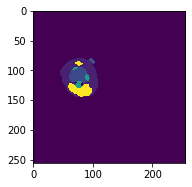

22


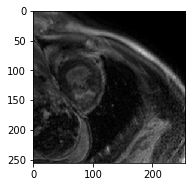

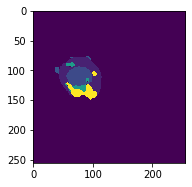

23


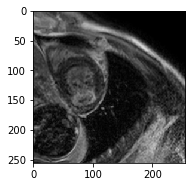

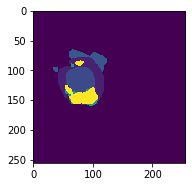

24


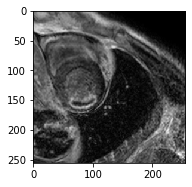

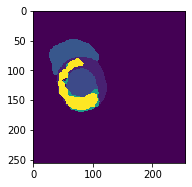

25


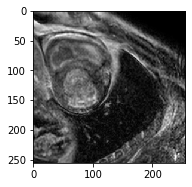

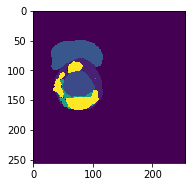

26


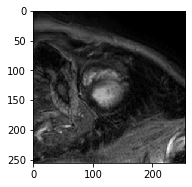

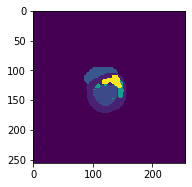

27


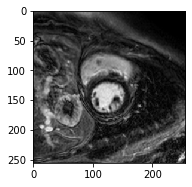

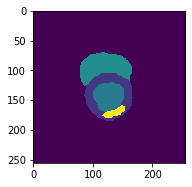

28


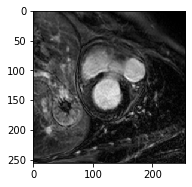

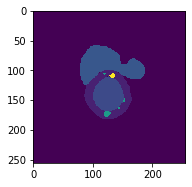

29


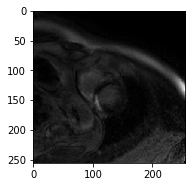

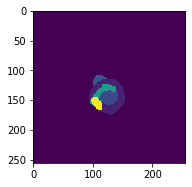

30


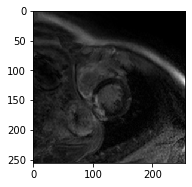

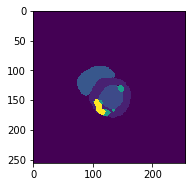

31


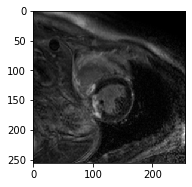

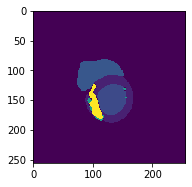

32


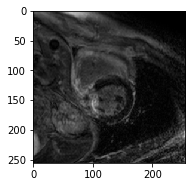

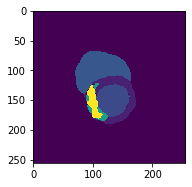

33


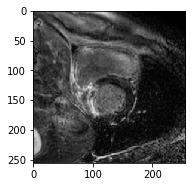

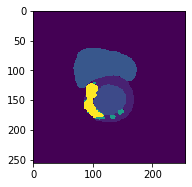

34


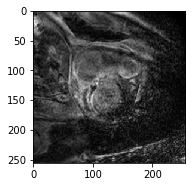

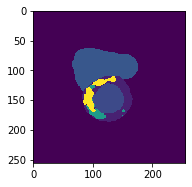

35


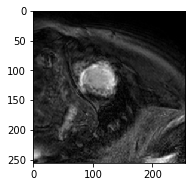

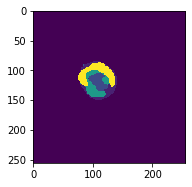

36


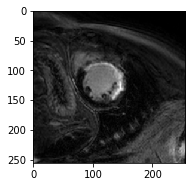

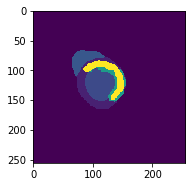

37


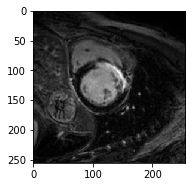

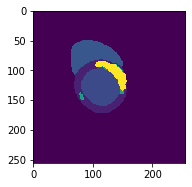

38


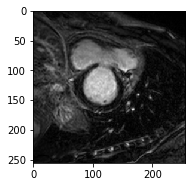

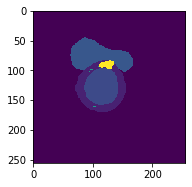

39


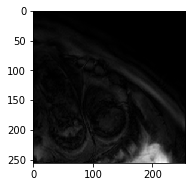

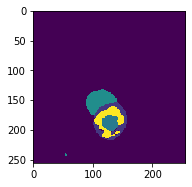

40


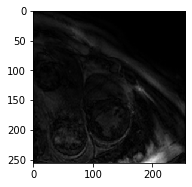

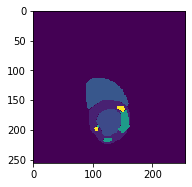

41


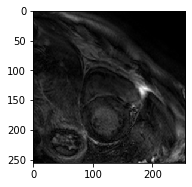

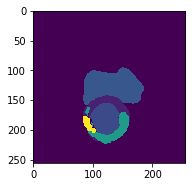

42


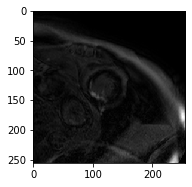

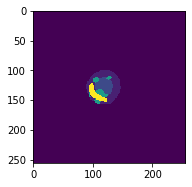

43


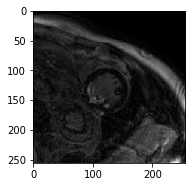

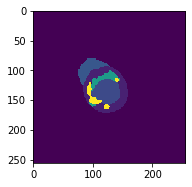

44


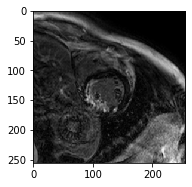

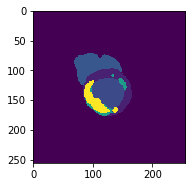

45


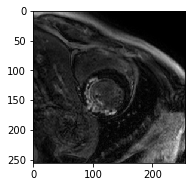

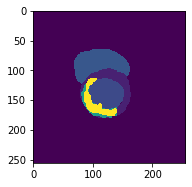

46


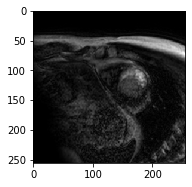

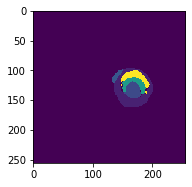

47


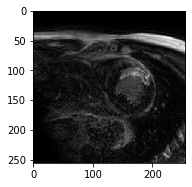

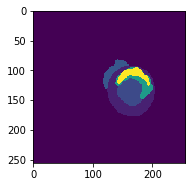

48


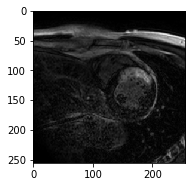

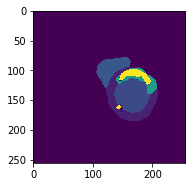

49


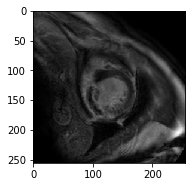

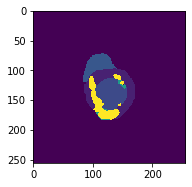

50


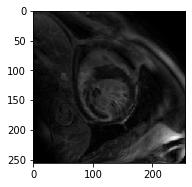

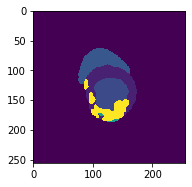

51


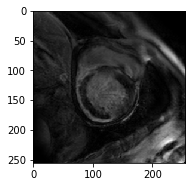

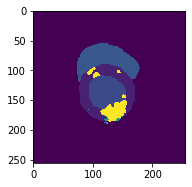

52


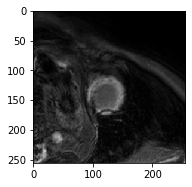

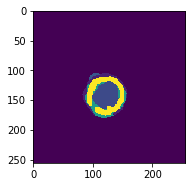

53


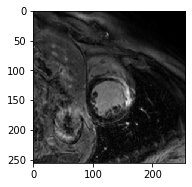

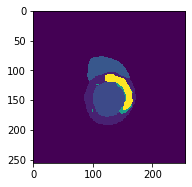

54


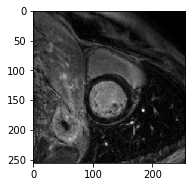

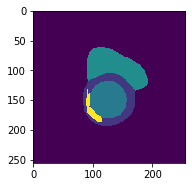

55


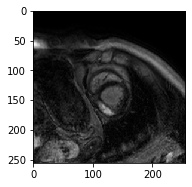

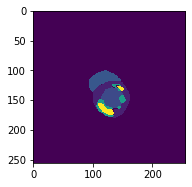

56


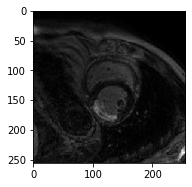

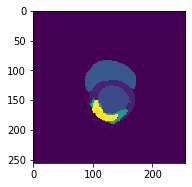

57


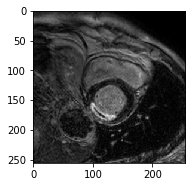

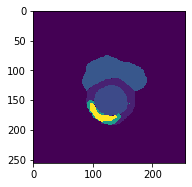

58


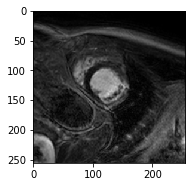

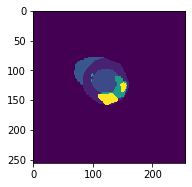

59


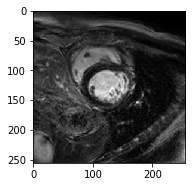

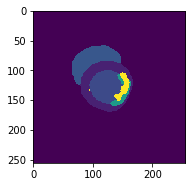

60


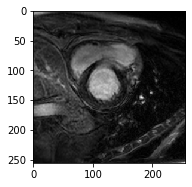

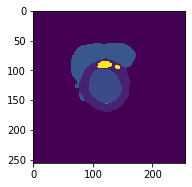

61


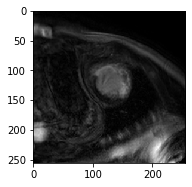

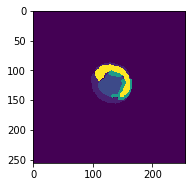

62


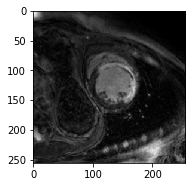

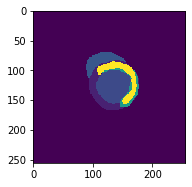

63


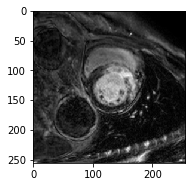

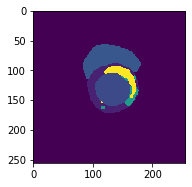

64


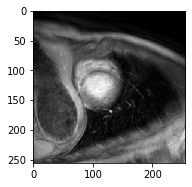

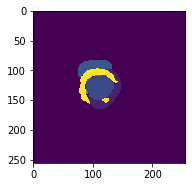

65


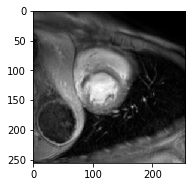

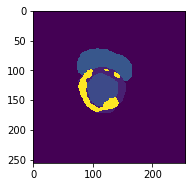

66


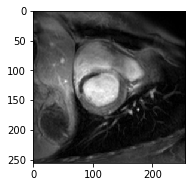

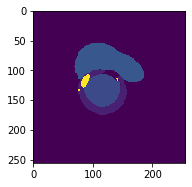

67


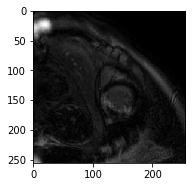

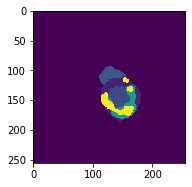

68


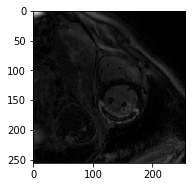

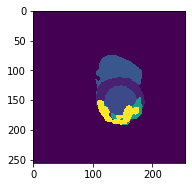

69


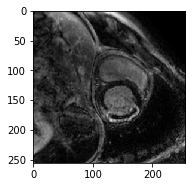

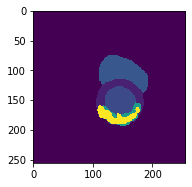

70


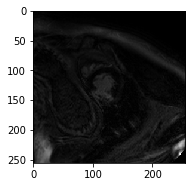

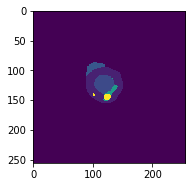

71


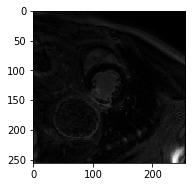

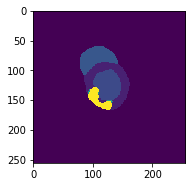

72


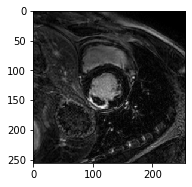

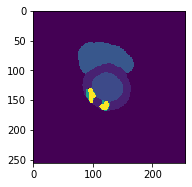

In [28]:
# Plots of the images with its predicted masks 
for i in range(len(preds)):
    print(i+1)    
    plt.subplot(1,2,1)
    plt.imshow(X_test256[i,:,:,1], cmap='gray')
    plt.show()
    plt.subplot(1,2,2)   
    plt.imshow(preds[i,:,:])
    plt.show()

In [29]:
#Saving the predicted masks into a new NIfTI file
C0=[x for x in files_test if 'C0' in x]
a=[]
for i in range(len(C0)):
    c=nib.load(C0[i]).shape[2]
    a.append(c)

b=[]
for i in range(len(a)+1):
    b.append(np.sum(a[0:i]))  

for i in range(len(b)-1):
    h=nib.load(C0[i]).shape[0]
    w=nib.load(C0[i]).shape[1]
    arr1= np.zeros((a[i],h,w))
    arr= np.zeros((a[i],400,400)).astype('uint16')
    k=int(b[i])
    l=int(b[i+1])
    array=preds[k:l,:,:]
    for j in range(a[i]):
        arr[j,72:328,72:328]=array[j,:,:]
        arr1[j,:,:]=cv2.resize(arr[j,:,:],(w,h),interpolation=cv2.INTER_NEAREST).astype('uint16')     
       
    arr1=arr1.transpose([1,2,0]).astype('uint16')
    img = nib.Nifti1Image(arr1,affine=nib.load(C0[i]).affine, header=nib.load(C0[i]).header) 
    nib.save(img,str(C0[i][7:21])+'.nii')